# FISCAS - SINGLE-CELL ROI Generator

This tool generates .mis files for Brukers FlexImaging software with regions of interest (ROIs) around single cells to save measurement time by avoiding the measurement of too many background pixels. To use this tool you need a fluorescence image of the membranes of your cell samples with fiducial markers that you can detect both in the fluorescence image as well as with the in source camera of your mass spectrometer. You can introduce those for example by marking parts of your slide with a fluorescent marker and then scratching lines into this marking. Then you use the fiducial markers for the built in image registration. Try to to do the registration as precise as possible to grantuee a proper fit of the regions around the cells. During this process FlexImaging will transform your input image in a way that it matches with you stage coordinates. You need this image as well as the FlexImaging File you created to run this script.

Start by importing all modules

In [43]:
# import all needed packages
import imageio
import matplotlib.pyplot as plt
import skimage
import numpy as np
import scipy
from scipy import signal
import timeit
from PIL import Image
import cv2
import xml.etree.ElementTree as ET
import os
import ipywidgets as widgets
from ipywidgets import interact, interactive
from IPython.display import display
# increase the maximum amount of pixels that the Image package is allowed to work with
Image.MAX_IMAGE_PIXELS = 1000000000

In [2]:
# dynamic plots
%matplotlib notebook

Now you need to define the path variables to your images. For the `mic_img_path` variable you should use the path to the image generated by FlexImaging.

`x` and `y` define the starting and end points of a rectangular region in which you want to generate regions of interest. The values need to be between 0 and 1. Values of 
`x_start=0`
`x_end=0.5`
`y_start=0`
`y_end=1`
would correspond to the left half of the image.

In [88]:
# define all the variables
# path to microscopy image of the source
# it is important that you use the image which gets generated by fleximaging during the teaching process
mic_img_path = r""
# path to MS method
method_path = r""
# path to pre generated .mis file
mis_input_path = r""
# path to output .mis file
mis_output_path = r""
# is defined by the pixelsize you want to measure at
pixelsize = 5

# define a rectangular region around your cells 
# values should be between 0 and 1 and are relative to the image (x_start=0, x_end=1 -> whole x-axis)
x_start = 0.15
x_end = 0.85
y_start = 0.15
y_end = 0.85

The next cell will load and the images and cut out out your selected region.

<IPython.core.display.Javascript object>


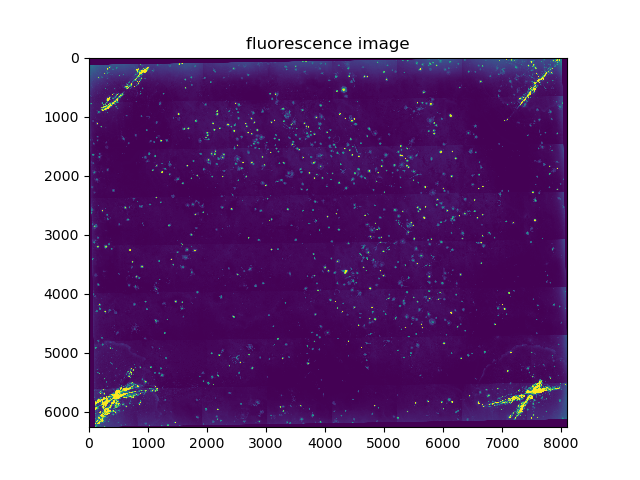

<IPython.core.display.Javascript object>


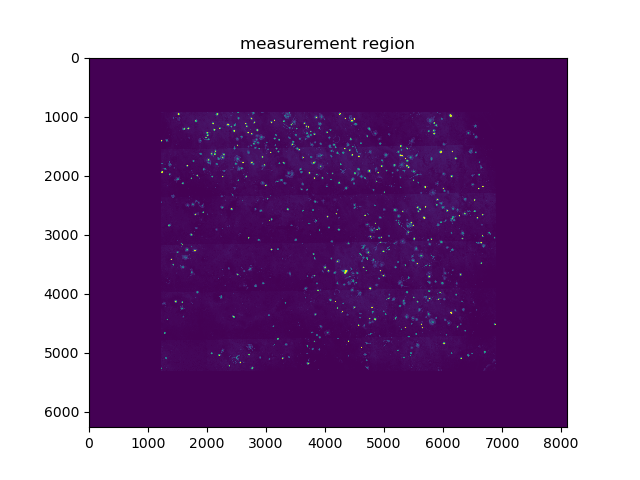

Text(0.5, 1.0, 'measurement region')

In [4]:
# read in image and extract the FITC channel
mic_img = imageio.v2.imread(mic_img_path)
mem_img = np.zeros((len(mic_img), len(mic_img[0])))
mem_img = skimage.exposure.rescale_intensity(mic_img[:,:,1])
plt.figure()
plt.title("fluorescence image")
plt.imshow(mem_img)
mem_img_cut = np.zeros(mem_img.shape)
mem_img_cut[int(len(mem_img)*y_start) : int(len(mem_img)*y_end), int(len(mem_img[0])*x_start) : int(len(mem_img[0])*x_end)] = mem_img[int(len(mem_img)*y_start) : int(len(mem_img)*y_end), int(len(mem_img[0])*x_start) : int(len(mem_img[0])*x_end)]
plt.figure()
plt.imshow(mem_img_cut)
plt.title("measurement region")

Now you need to optimize the parameters for the ROI generation. 

`growing_iter`: determines how big the regions around the cells are

`otsu_scaling`: determines the intensity threshold to segment between foreground (cells) and background (noise level)

`opening_iter`: determines the amount of smoothing that is performed to remove artifacts

<IPython.core.display.Javascript object>


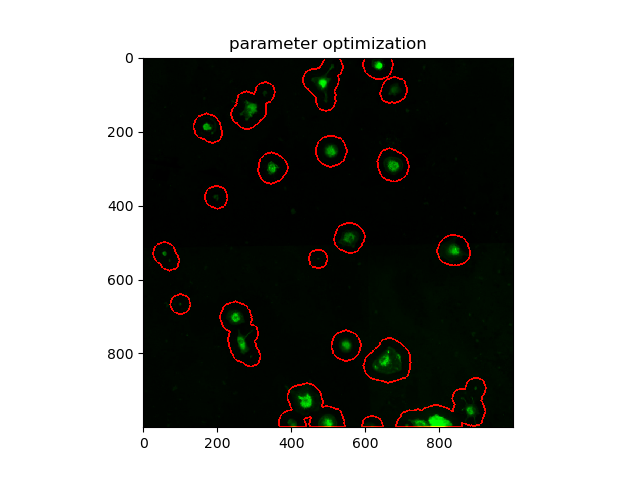

interactive(children=(IntSlider(value=10, description='growing_iter', max=20, min=1), FloatSlider(value=0.5, d…

In [82]:
def optimize_parameters(growing_iter=10, otsu_scaling = 0.5, opening_iter=2):
    # amount of iterations the regions are grown
    #growing_iter = 10
    # scaling factor for otsus method, smaller values correspond to a lower theshold and therefore larger cell areas
    #otsu_scaling = 0.2
    # create smaller sample image for parameter optimization
    size=500

    test_sample = np.zeros((size*2,size*2))
    # get center coordinates
    x = int(len(mem_img[0]) * 0.5)
    y = int(len(mem_img) * 0.5)
    test_sample = mem_img[y-size:y+size,x-size:x+size]
    thresh = skimage.filters.threshold_otsu(test_sample) * otsu_scaling
    eval_sample = np.zeros(test_sample.shape)
    eval_sample[test_sample > thresh] = 255
    if opening_iter > 0:
        mask_sample = scipy.ndimage.morphology.binary_opening(eval_sample, structure=None, iterations=int(opening_iter), output=None, origin=0)
    else:
        mask_sample = eval_sample
    r=5
    kernel = np.fromfunction(lambda x, y: ((x-r)**2 + (y-r)**2 <= r**2)*1, (2*r+1, 2*r+1), dtype=int).astype(np.uint8)
    dil_sample = cv2.dilate(np.float32(mask_sample), kernel, iterations = growing_iter)
    dil_sample = dil_sample.astype('uint8')
    dil_sample = dil_sample * 255
    contours, hierarchy = cv2.findContours(dil_sample, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    img_contours = np.zeros((mask_sample.shape[0], mask_sample.shape[1], 3), dtype='uint8')
    cv2.drawContours(img_contours, contours, -1, (0,255,0), 4)
    img_contours[tuple([mask_sample > 0, 0])] = 1
    overlay = np.zeros((len(mask_sample), len(mask_sample[0]), 3), dtype=int)
    overlay[:,:,1] = mem_img[y-size:y+size,x-size:x+size]
    overlay[:,:,0] = img_contours[:,:,1]
    plt.imshow(overlay)
    return growing_iter, otsu_scaling, opening_iter

plt.figure()
plt.title("parameter optimization")
w = interactive(optimize_parameters, growing_iter=(1,20), otsu_scaling = (0,1,0.01), opening_iter = (0,10))
display(w)

In [83]:
growing_iter, otsu_scaling, opening_iter = w.result

The next cell will apply the settings you made on the whole image and show you more detailed results

<IPython.core.display.Javascript object>


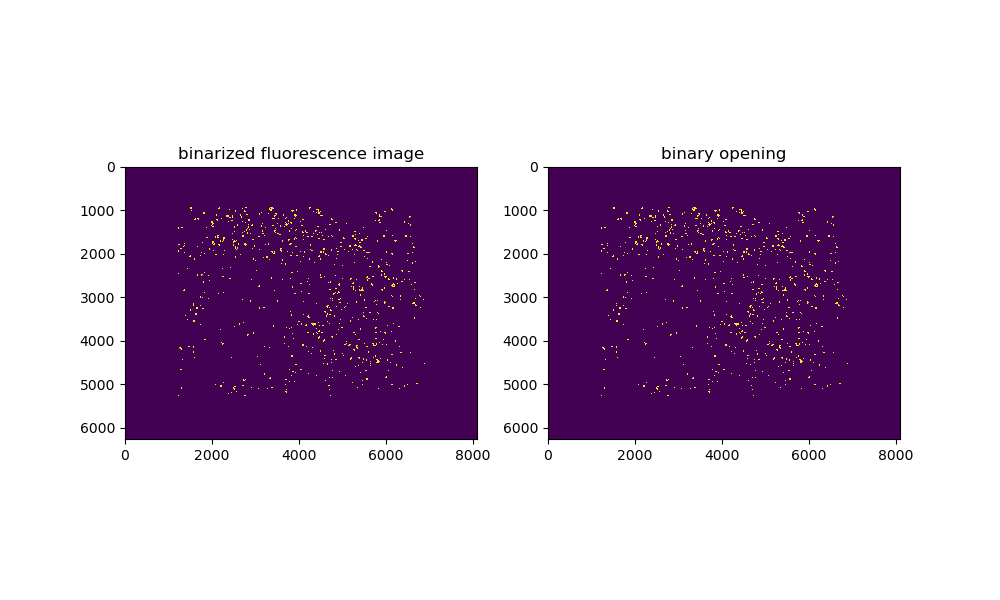

C:\Users\schwenzj\AppData\Local\Temp\ipykernel_12032\2064058589.py:11: DeprecationWarning: Please use `binary_opening` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  mask = scipy.ndimage.morphology.binary_opening(mem_img_bin, structure=None, iterations=int(opening_iter), output=None, origin=0)


1451


<IPython.core.display.Javascript object>


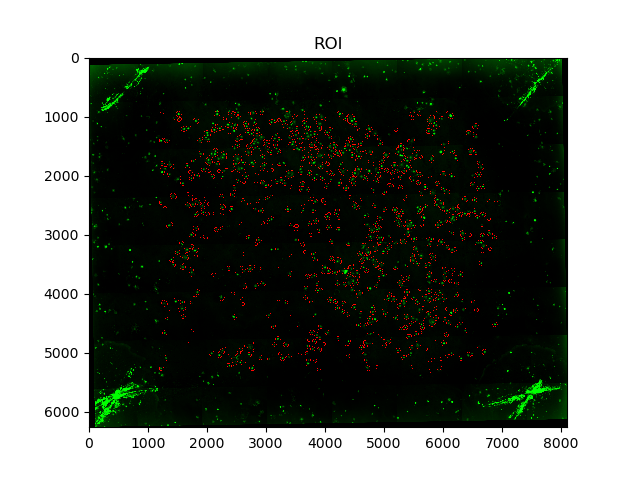

In [86]:
# binarize the image
thresh = skimage.filters.threshold_otsu(mem_img) * otsu_scaling
mem_img_bin = np.zeros(mem_img.shape)
mem_img_bin[mem_img_cut > thresh] = 255
fig, ax = plt.subplots(1,2,figsize=(10,6))
ax[0].imshow(mem_img_bin)
ax[0].set_title("binarized fluorescence image")

# binary opening of the image mask to reduce artifacts
if opening_iter > 0:
    mask = scipy.ndimage.morphology.binary_opening(mem_img_bin, structure=None, iterations=int(opening_iter), output=None, origin=0)
else:
    mask = mem_img_bin
ax[1].imshow(mask)
ax[1].set_title("binary opening")

num_labels, label_img = cv2.connectedComponents(mask.astype(np.uint8))
print(num_labels)

# define kernel dimensions
r=5
kernel = np.fromfunction(lambda x, y: ((x-r)**2 + (y-r)**2 <= r**2)*1, (2*r+1, 2*r+1), dtype=int).astype(np.uint8)

# binary dilation of the mask to create cell margin
mask_dil = cv2.dilate(np.float32(mask), kernel, iterations = growing_iter)
mask_dil = mask_dil.astype('uint8')
mask_dil_uint = mask_dil * 255

# create contours around the masks
contours, hierarchy = cv2.findContours(mask_dil_uint, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
img_contours = np.zeros((mask.shape[0], mask.shape[1], 3), dtype='uint8')
cv2.drawContours(img_contours, contours, -1, (0,255,0), 4)
img_contours[tuple([mask > 0, 0])] = 1
overlay = np.zeros((len(mask), len(mask[0]), 3), dtype=int)
overlay[:,:,1] = mem_img
overlay[:,:,0] = img_contours[:,:,1]
plt.figure()
plt.title("ROI")
plt.imshow(overlay)

Finally its time to generate your .mis file using the ROIs we just generated. 

In [89]:
# modify input .mis file

# deals with correct indentations in xml files
def indent(elem, level=0):
    i = os.linesep + level*"  "
    if len(elem):
        if not elem.text or not elem.text.strip():
            elem.text = i + "  "
        if not elem.tail or not elem.tail.strip():
            elem.tail = i
        for elem in elem:
            indent(elem, level+1)
        if not elem.tail or not elem.tail.strip():
            elem.tail = i
    else:
        if level and (not elem.tail or not elem.tail.strip()):
            elem.tail = i


tree = ET.parse(mis_input_path)
root = tree.getroot()

# adds a region for every element in contours
for i in range(len(contours)):
    area = ET.Element("Area")
    # type 3 corresponds to freeform area
    area.attrib["Type"] = "3"
    # assign a unique name to the area
    area.attrib["Name"] = str(i)
    area.attrib["ZoomArea"] = "0"
    area.attrib["Enabled"] = "0"
    area.attrib["ShowSpectra"] = "0"
    area.attrib["SpectrumColor"] = "#993333"
    
    raster = ET.SubElement(area, "Raster")
    raster.text = "{a},{a}".format(a=pixelsize)
    
    method = ET.SubElement(area, "Method")
    # assign the correct method to each region
    method.text = method_path
    
    # add the coordinates for each contour 
    for j in contours[i]:
        point = ET.SubElement(area, "Point")
        point.text = str(j[0][0]) + "," + str(j[0][1])
        

    root.append(area)
tree = ET.ElementTree(root)

indent(root)

#write the output file
with open(mis_output_path, 'wb') as f:
    tree.write(f, xml_declaration=False, encoding = 'utf-8')
    
square_area = len(mask) * len(mask[0])
cell_area = np.count_nonzero(mask_dil)
ratio = cell_area / square_area
print("{a:.1f} % of the image corresponds to cells. You have saved roughly a factor of {b:.1f} in measurement time.".format(a=ratio*100, b=1/ratio))

8.1 % of the image corresponds to cells. You have saved roughly a factor of 12.4 in measurement time.
